In [312]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

# Visualization packages
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io, filters, constants
from analysis import analysis_util, analysis_constants, visualization_util
from web_analysis import parse_robots
from web_analysis import robots_util


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
url_token_lookup = robots_util.URLTokenLookup('pretrain_data/relevant_url_token_counts.csv') # 'c4', 'rf', 'dolma'
c4_url_to_counts = url_token_lookup.get_url_to_token_map("c4")

In [8]:
# URL -> Date -> Robots.txt raw text
head_robots = io.read_json("robots_data/temporal_robots_head.json")
random_10k_robots = io.read_json("robots_data/temporal_robots_rand_10k.json")
joined_robots = copy.deepcopy(head_robots)
joined_robots.update(random_10k_robots)
print(len(head_robots))
print(len(random_10k_robots))
print(len(joined_robots))

830
6230
7059


In [9]:
# Print out start and end years of the data:

all_times = []
for k, vs in joined_robots.items():
    for time in vs:
        all_times.append(time)
all_times = set(all_times)
print(min(all_times))
print(max(all_times))
print(sorted(all_times)[:10])
print(sorted(all_times)[-10:])

2016-01-01
2024-04-19
['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10']
['2024-04-10', '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19']


In [11]:
agent_groups_to_track = robots_util.get_bot_groups()
agents_to_track = robots_util.get_bots()
# {URL --> Date --> Agent --> Status}
url_robots_summary = robots_util.compute_url_date_agent_status(
    data=joined_robots, 
    # relevant_agents=agents_to_track)
    relevant_agents=[v for vs in agent_groups_to_track.values() for v in vs])

In [12]:
# top N sample: TODO: Top 1k vs top 800 token info.
top_c4_urls = url_token_lookup.top_k_urls("c4", 1000)
url_robots_summary_head = {k: url_robots_summary[k] for k in top_c4_urls if k in top_c4_urls}
url_robots_summary_rand = {k: url_robots_summary[k] for k, _ in random_10k_robots.items()}

Number of tokens in 1000 URLs: 13808461301 | 8.12% of c4


In [289]:
size_bucket_to_urls = robots_util.bucket_urls_by_size(
    c4_url_to_counts, 
    bucket_boundaries=[0, 1000, 10000, 50000, 1000000, 10000000, 50000000, 9999999999999999]
)

Bucket 0-1000: 4729
Bucket 1000-10000: 4064
Bucket 10000-50000: 1411
Bucket 50000-1000000: 896
Bucket 1000000-10000000: 2441
Bucket 10000000-50000000: 429
Bucket 50000000-9999999999999999: 19


In [307]:
robots_util.plot_size_against_restrictions(
    url_robots_summary,
    size_bucket_to_urls,
    "OpenAI",
    setting="train"
)

7059
defaultdict(<function plot_size_against_restrictions.<locals>.<lambda> at 0x1366ec820>, {'10000000-50000000': [77, 167, 109], '1000000-10000000': [73, 223, 172], '50000000-9999999999999999': [5, 8, 4], '10000-50000': [16, 636, 327], '0-1000': [36, 1315, 886], '50000-1000000': [11, 220, 133], '1000-10000': [43, 1684, 914]})


alt.LayerChart(...)

In [296]:

# {Period --> Agent --> Status --> set(URLs)}
robots_filled_status_head_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_head, 
    # group_to_agents={k: [k] for k in agents_to_track},
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
)
robots_filled_status_rand_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_rand, 
    # group_to_agents={k: [k] for k in agents_to_track},
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
)


2016-01


../web_analysis/robots_util.py:242: UserWarning: Discarding nonzero nanoseconds in conversion.
  


2016-11
2017-09
2018-07
2019-05
2020-03
2021-01
2021-11
2022-09
2023-07
2016-01
2016-11
2017-09
2018-07
2019-05
2020-03
2021-01
2021-11
2022-09
2023-07


In [297]:

# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_head_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_head_summary,
    url_to_counts=c4_url_to_counts,
)
# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_rand_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_rand_summary,
    url_to_counts=c4_url_to_counts,
)

In [285]:
# robots_temporal_head_summary

In [ ]:
url_to_info = analysis_util.extract_url_annotations(["annotated_websites/Task 1", "annotated_websites/Task 2"])
url_results_df = pd.DataFrame(analysis_util.process_url_annotations(url_to_info))
url_results_df = analysis_util.encode_size_columns(url_results_df, url_token_lookup)

url_correlation_df = analysis_util.analyze_url_variable_correlations(url_results_df, [100, 500, 2000], "dolma")

# Convert the dataframe to a LaTeX table
latex_table = url_correlation_df.to_latex(index=True, escape=True, float_format="{:.1f}".format)
print(latex_table)

In [335]:
def encode_latest_tos_robots_into_df(
    url_results_df,
    tos_policies,
    url_robots_summary,
    companies,
):

    recent_url_robots, recent_url_tos_verdicts = robots_util.prepare_recent_robots_tos_info(
        tos_policies, url_robots_summary, companies
    )
    url_results_df["robots"] = url_results_df["URL"].map(recent_url_robots)
    url_results_df['robots'].fillna('none', inplace=True)
    url_results_df["ToS"] = url_results_df["URL"].map(recent_url_tos_verdicts)
    url_results_df['ToS'].fillna('No Restrictions', inplace=True)
    return url_results_df
    
    



In [336]:
encode_latest_tos_robots_into_df(
    url_results_df, tos_policies, url_robots_summary,
    ["Google", "OpenAI", "Anthropic", "Cohere", "Common Crawl", "Meta"]
)

7059


,URL,User Content,Domains,Services,Paywall,Ads,Modality: Image,Modality: Video,Modality: Audio,Sensitive Content,c4 tokens,c4 rank,rf tokens,rf rank,dolma tokens,dolma rank,sample,robots,ToS
0,radaronline.com,False,"[News, Entertainment & Culture]",[News/Periodicals],False,True,True,True,False,False,0,13598,12986584,1874,32410215,2287,top,none,No Restrictions
1,tpmcafe.talkingpointsmemo.com,False,"[News, Legal & Policy]",[News/Periodicals],True,True,True,False,True,False,0,13768,13885085,1718,0,13774,top,none,No Restrictions
2,www.medpagetoday.com,False,"[News, Science, Academia, & Technology]",[News/Periodicals],True,True,True,False,True,False,2845027,2274,26946662,685,40604734,2036,top,none,No Restrictions
3,www.archive.org,False,"[Books, General Information & Education]",[Encyclopedia/Database],False,False,True,True,True,False,300186,3238,430479229,8,21716945,2739,top,none,No Restrictions
4,www.authorstream.com,False,[General Information & Education],[Other],False,False,True,True,False,False,352515,3202,20447738,1021,45211642,1777,top,none,No Restrictions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,www.graphic.com.gh,False,"[News, General Information & Education]",[News/Periodicals],False,True,True,True,False,False,3784075,1996,3063702,3148,18055341,2901,top,none,No Restrictions
3013,muse.jhu.edu,False,"[General Information & Education, Science, Aca...",[Academic],False,False,True,False,False,False,3783720,1997,32479495,541,78421759,747,top,none,No Restrictions
3014,www.musicianguide.com,False,"[Entertainment & Culture, General Information ...",[Encyclopedia/Database],False,False,True,False,False,False,3783498,1998,2474094,3263,3171675,3583,top,none,No Restrictions
3015,www.belfastlive.co.uk,False,"[News, General Information & Education]",[News/Periodicals],False,False,True,True,False,False,3783211,1999,8002375,2427,35109383,2191,top,none,No Restrictions


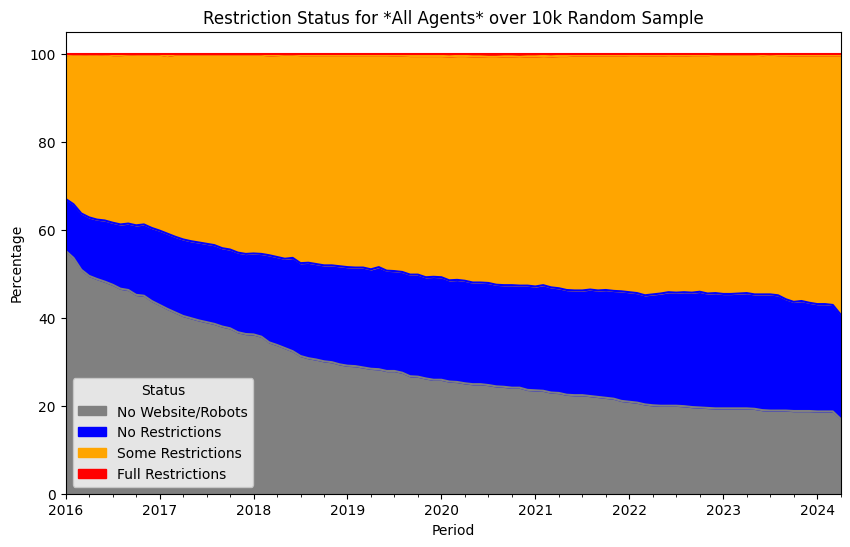

<Figure size 640x480 with 0 Axes>

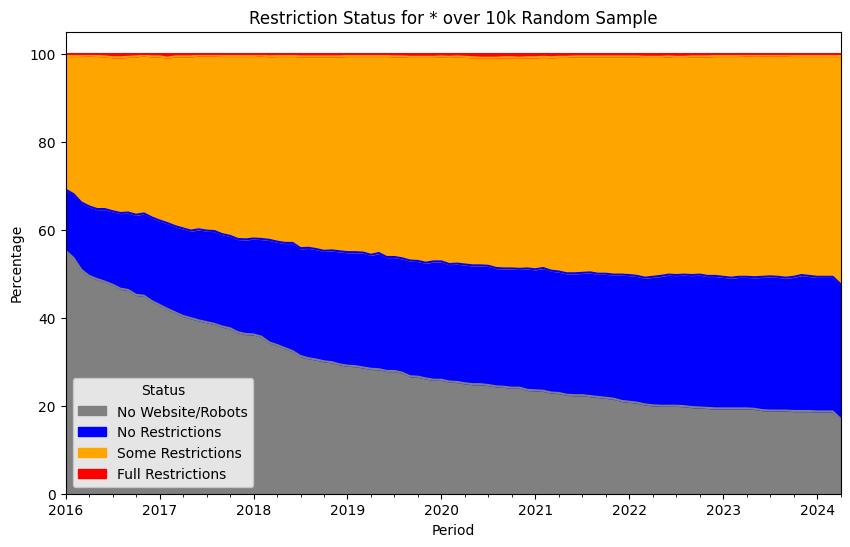

<Figure size 640x480 with 0 Axes>

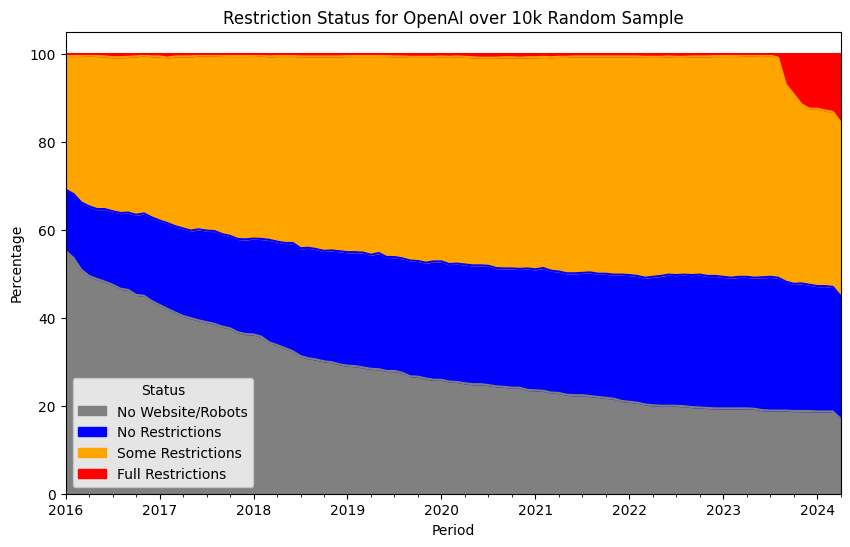

<Figure size 640x480 with 0 Axes>

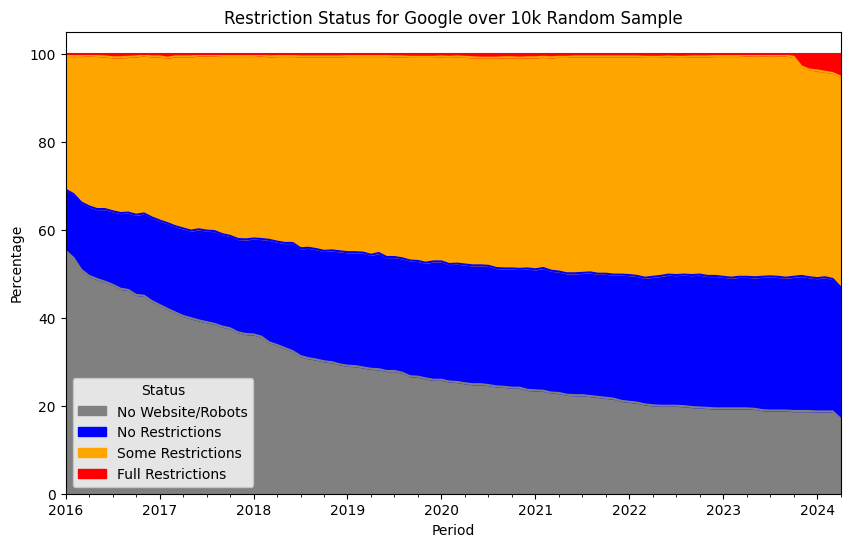

<Figure size 640x480 with 0 Axes>

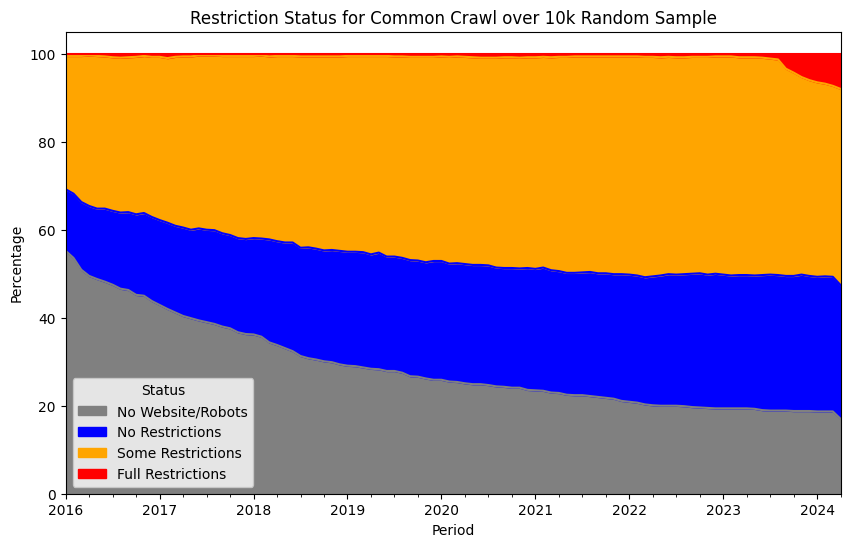

<Figure size 640x480 with 0 Axes>

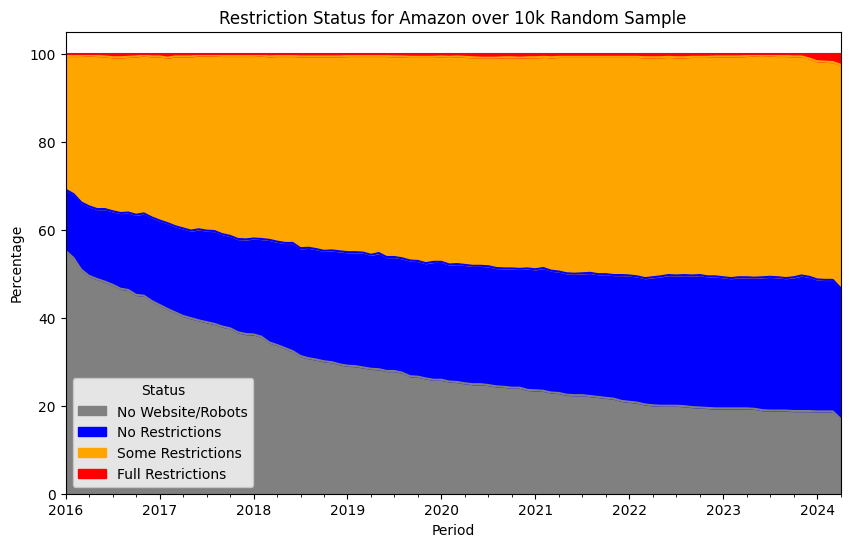

<Figure size 640x480 with 0 Axes>

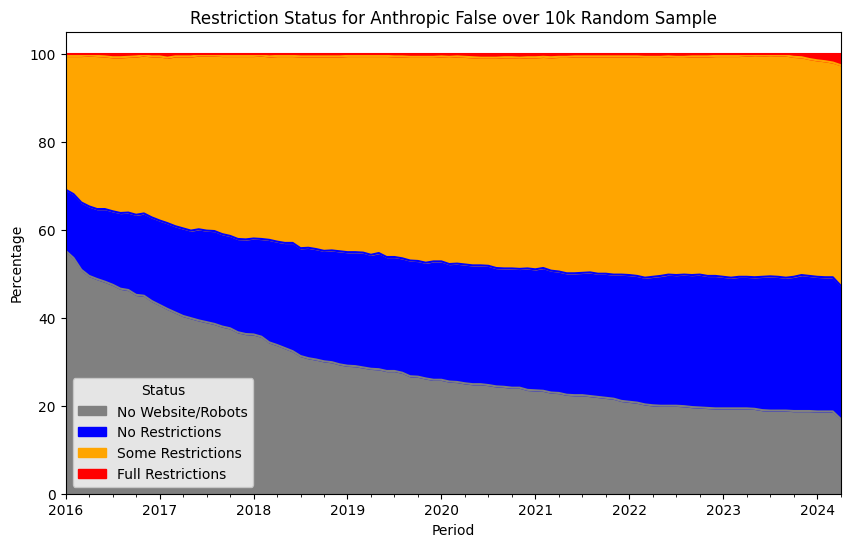

<Figure size 640x480 with 0 Axes>

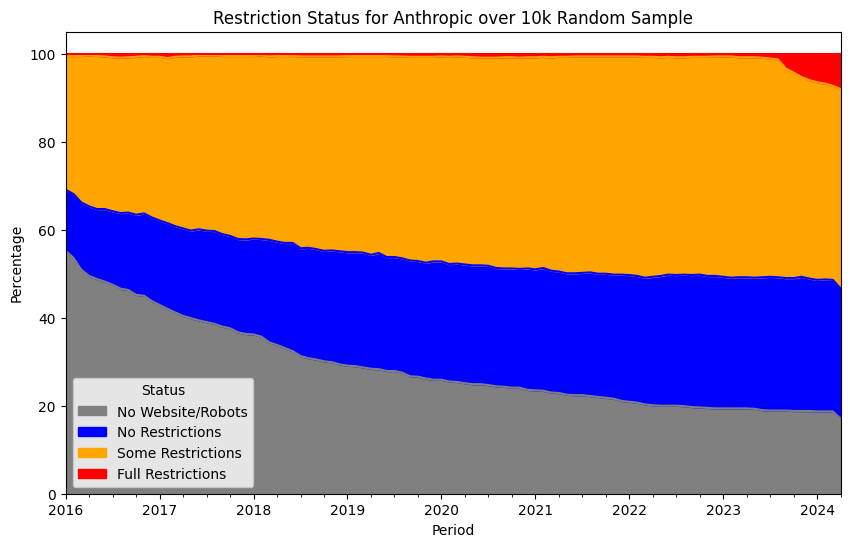

<Figure size 640x480 with 0 Axes>

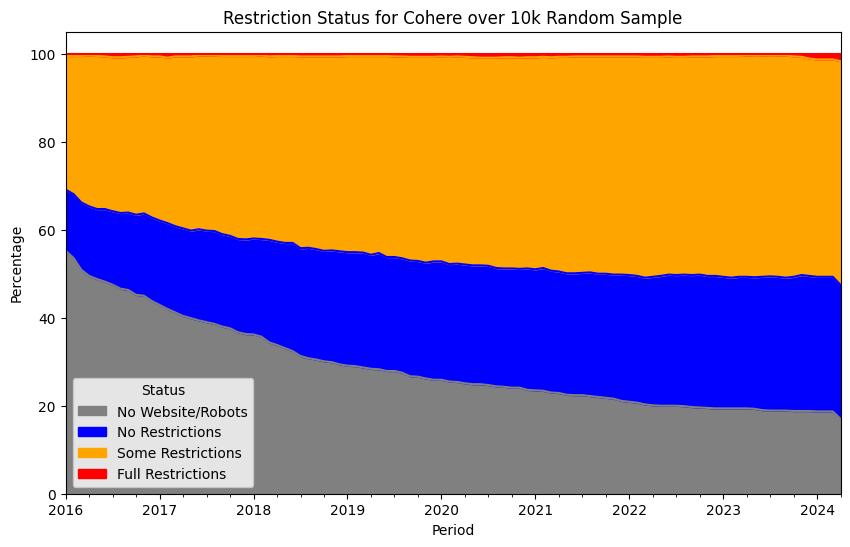

<Figure size 640x480 with 0 Axes>

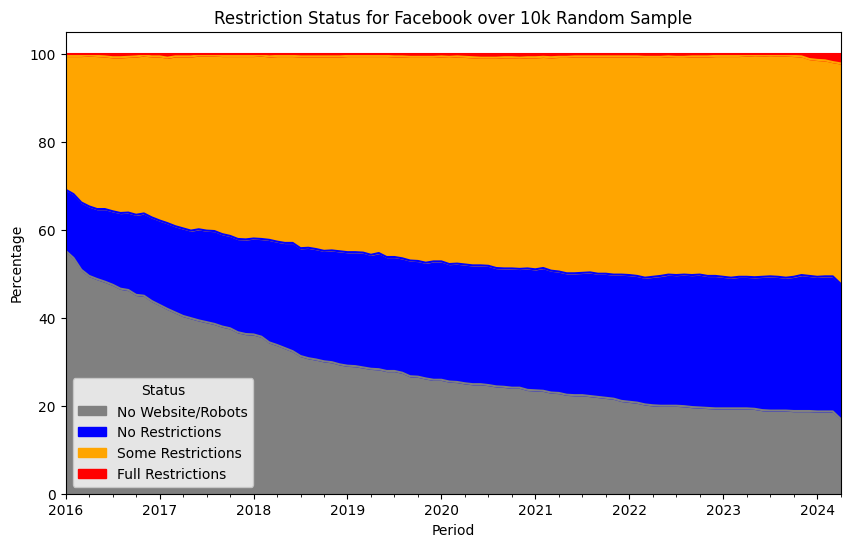

<Figure size 640x480 with 0 Axes>

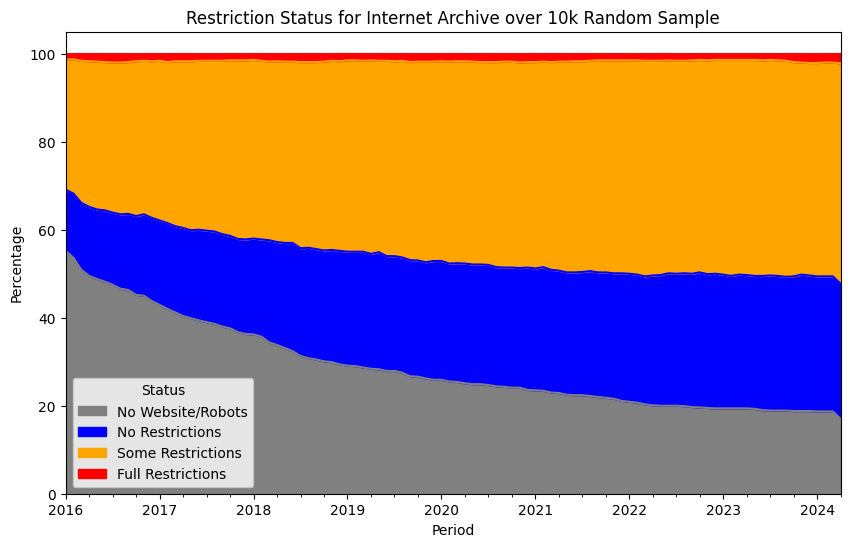

<Figure size 640x480 with 0 Axes>

In [308]:


# for agent in agents_to_track:
#     robots_util.plot_robots_time_map(robots_temporal_summary, agent)

for group in agent_groups_to_track:
    robots_util.plot_robots_time_map(robots_temporal_head_summary, group, val_key="count")

In [ ]:
# 2. "*" over time, compared to a few agents [Google, OpenAI, Meta, Cohere, Anthropic, etc]

In [ ]:
Notes:

* Take All Agents and subtract it from the other plots to see the diffs between agents.
* How do these charts vary with different quantiles for number of tokens. (Behavior diffs for token rich and token poor)

* Incompatability between Robots.txt and ToS? Robots.txt is an encoded ToS for scrapers. Is there more intention detailed in the ToS than the robots?
* Robots and ToS update rate. --> How often that the other is updated within T time (robots and ToS).
* Analysis: Of all websites that restrict at least one AI bot, what other bots do they restrict? E.g. if you restrict cohere, you probaby also restrict OpenAI
P(Cohere restricted | OpenAI restricted)
* Include Midjourney, CCBot, IAbot, etc
* Vertical lines that show when bots get introduced.

* Restrictions are rising across the board.
* Company-wise restrictions
* Compare for each company their scraping restrictions vs RAG restrictions vs AI bot restrictions (OpenAI, Anthropic)

In [ ]:
- company-wise analysis: by agent, by RAG, by scraping
- rate of change over time
- most added agent in each period (bi-annually?)
- token quantity-adjusted
- correlation between token size and robots.txt restrictions?
- overleaf table for agent mentions and status

In [327]:
def prepare_tos_robots_confusion_matrix(
    tos_policies,
    url_robots_summary,
    companies,
    url_token_lookup,
    corpora_choice="c4",
):
    recent_url_robots, recent_tos_verdicts = robots_util.prepare_recent_robots_tos_info(
        tos_policies, url_robots_summary, companies,
    )

    return visualization_util.plot_confusion_matrix(
        url_robots_status,
        url_tos_verdicts,
        url_token_counts=url_token_lookup.get_url_to_token_map(corpora_choice),
        status_order=["Restricted", "Partial", "None"],
        policy_order=["No Restrictions", "Conditional Restrictions", "Prohibits AI", "Prohibits Scraping", "Prohibits Scraping & AI"],
        font_size=16, 
        font_style='Times',
        width=600,
        height=400,
    )

In [328]:
tos_policies = io.read_json("robots_data/tos_ai_scraping_policies.json")
print(len(tos_policies))

3068


In [332]:
prepare_tos_robots_confusion_matrix(
    tos_policies,
    url_robots_summary,
    ["Google", "OpenAI", "Anthropic", "Cohere", "Common Crawl", "Meta"],
    url_token_lookup,
    corpora_choice="c4",
)

7059


alt.LayerChart(...)

In [ ]:
# clean-up
# Legend
# set fonts and sizes and legend

In [261]:
# c4_top2k_counts

In [ ]:
Data Sources Analysis:

0. Table: Methodology -- what metadata we collected/annotated (and how). [WIP]
1. Figure: Temporal changes in Robots / ToS (somehow over a collection or multiple companies?) [Waiting on ToS]
    C4/RF/(Dolma) vs (2k-Head)/Random vs Company(6)
2. Figure: Robots / ToS contradiction matrix [Waiting on ToS]
    Creative Commons.
3. Table: Robots permission differences by company + Stella(pairwise differences by confusion matrix) [WIP]
4. Table: Robots / ToS / other indicators variability by website num tokens (i.e. head vs tail) [WIP]
5. Figure: Commercial/market copyright concerns and comparison to WildChat + EU AI Act [WIP, waiting on WildChat]

In [ ]:
Datasets Analysis:

(License: NC, C, Unspecified) x (Terms: Unspecified/None, NC, C).
Text =~ 200
Video = 11
Speech ~= 50

0. Tables for Text, Video, Speech [Will: WIP]
1. License & source (terms) restriction differences between Text, Video, Speech. (normalized stacked bar chart) [WIP]
2. Source domains by Text, Video, Speech: scraped, synthetic, crowdsourced, ....  (normalized stacked bar chart) [WIP]
2b. Include pretraining (broken down by modality + user content + illicit content)
3. Creator distribution for Text, Video, Speech by geography and organization type [WIP]

Extension: 


4. Temporal breakdown of license restriction categories by Text, Video, Speech [WIP]
5. License Type by modality for Text, Video, Speech [WIP]
6. Languages / Tasks.
(Will run statistical tests checking if diffs between Text,Video,Speech are significant on all of these. [WIP]

In [ ]:


# People who restrict Anthropic but not OpenAI. <-- public awareness of organizations is the driving force here. 
# Ordered by notoriety. (Confusion matrix)

In [31]:
nayan = pd.read_csv("test_data/wildchat_annotations.csv")

In [3]:
# nayan

In [400]:
def sample_nayan(df, i):
    row = df.iloc[i]
    prompt = row["WildChat Example Prompt"]
    response = row["WildChat Example Response"]
    typs = row["Types of Service"]
    cd = row["Content Domain"]
    print(prompt)
    # print("*************" + response[:100])
    print(cd)
    print()

In [1]:
# for i in range(30, 60):
#     sample_nayan(nayan, i)